# Лабораторная работа №6

## 6.1. Квантовые коды коррекции ошибок

In [1]:
import numpy as np

In [2]:
import copy

Задаём число кубитов и размерность гильбертового пространства состояний рассматриваемой квантовой системы.

In [3]:
n = 5
d = 2 ** n

Задаём состояние первого кубита $|\psi\rangle$ и расширяем его до 5-кубитного состояния $|\psi\rangle \otimes |0\rangle \otimes |0\rangle \otimes |0\rangle \otimes |0\rangle$.

In [4]:
psi_0 = (1 / np.sqrt(5)) * np.array([np.sqrt(2), -1j * np.sqrt(3)], dtype=complex)
psi_0_aux = np.zeros(2 ** (n - 1), dtype=complex)
psi_0_aux[0] = 1.0
psi_0 = np.kron(psi_0, psi_0_aux)

Задаём необходимые гейты.

In [5]:
I = np.array([[1, 0],
              [0, 1]], dtype=complex)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)

Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                 [1, -1]], dtype=complex)

CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]], dtype=complex)

TOFFOLI_Z = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 0, -1]], dtype=complex)

Создаём функции, которые будут из однокубитных, двухкубитных и трёхкубитных матриц создавать матрицу, отвечающую $5$-кубитному гейту (для двухкубитных и трёхкубитных гейтов используем битовое представление индексов, для этого используем функцию bin()).
Напишем подробнее, как мы строим $5$-кубитную матрицу двухкубитного гейта, зная двухкубитную матрицу двухкубитного гейта (для трёхкубитных гейтов аналогично). Пусть $\hat{U}_{1, 3}$ - оператор двухкубитного гейта, который действует на $1$ и $3$ кубит (для примера).
Тогда элемент $5$-кубитной матрицы гейта записывается следующим образом: $U_{i_1 i_2 i_3 i_4 i_5, j_1 j_2 j_3 j_4 j_5} = \langle i_1| \otimes \langle i_2| \otimes \langle i_3| \otimes \langle i_4| \otimes \langle i_5| \hat{U} |j_1\rangle \otimes |j_2\rangle \otimes |j_3\rangle \otimes |j_4\rangle \otimes |j_5\rangle = \langle i_1| \otimes \langle i_3| \hat{U} |j_1\rangle \otimes |j_3\rangle \delta_{i_2 j_2} \delta_{i_4 j_4} \delta_{i_5 j_5}$.

In [6]:
def one_qubit_gate_n(gate, n, k):
    return np.kron(np.kron(np.eye(2 ** k, dtype=complex), gate), np.eye(2 ** (n - k - 1), dtype=complex))

In [7]:
def two_qubit_gate_n(gate, n, k, l):
    gate_nq = np.eye(2 ** n, dtype=complex)
    for i in range(2 ** n):
        for j in range(2 ** n):
            bin_str_i = list(bin(i)[2:].zfill(n))
            i1 = int("".join([bin_str_i[k]] + [bin_str_i[l]]), 2)
            bin_str_j = list(bin(j)[2:].zfill(n))
            j1 = int("".join([bin_str_j[k]] + [bin_str_j[l]]), 2)
            
            bin_str_i.pop(k)
            bin_str_i.pop(l - 1)
            
            bin_str_j.pop(k)
            bin_str_j.pop(l - 1)
            
            if int("".join(bin_str_i), 2) == int("".join(bin_str_j), 2):
                gate_nq[i, j] = gate[i1, j1]
    return gate_nq

In [8]:
def three_qubit_gate_n(gate, n, k, l, m):
    gate_nq = np.eye(2 ** n, dtype=complex)
    for i in range(2 ** n):
        for j in range(2 ** n):
            bin_str_i = list(bin(i)[2:].zfill(n))
            i1 = int("".join([bin_str_i[k]] + [bin_str_i[l]] + [bin_str_i[m]]), 2)
            bin_str_j = list(bin(j)[2:].zfill(n))
            j1 = int("".join([bin_str_j[k]] + [bin_str_j[l]] + [bin_str_j[m]]), 2)
            
            bin_str_i.pop(k)
            bin_str_i.pop(l - 1)
            bin_str_i.pop(m - 2)
            
            bin_str_j.pop(k)
            bin_str_j.pop(l - 1)
            bin_str_j.pop(m - 2)
            
            if int("".join(bin_str_i), 2) == int("".join(bin_str_j), 2):
                gate_nq[i, j] = gate[i1, j1]
    return gate_nq

Создаём функции, которые определяют действие однокубитных, двухкубитных и трёхкубитных гейтов на состояние $\psi$.

In [9]:
def one_qubit_gate(psi, gate, n, k):
    gate = one_qubit_gate_n(gate, n, k)
    psi_new = np.dot(gate, psi)
    return psi_new

In [10]:
def two_qubit_gate(psi, gate, n, k, l):
    gate = two_qubit_gate_n(gate, n, k, l)
    psi_new = np.dot(gate, psi)
    return psi_new

In [11]:
def three_qubit_gate(psi, gate, n, k, l, m):
    gate = three_qubit_gate_n(gate, n, k, l, m)
    psi_new = np.dot(gate, psi)
    return psi_new

Нарисуем общую схему, которую мы реализуем. В неё входит схема кодирования трёхкубитового кода коррекции, затем действие ошибок, дальше используется схема для определения синдрома ошибки, а затем уже с помощью трёхкубитных Z-Тоффоли исправляем фазовые ошибки. Проанализировав эту схему, легко понять, что синдромы ошибки, соответствующие определённым фазовым ошибкам, следующие:
11 - Z-ошибка во 2 кубите, 10 - Z-ошибка в 3 кубите, 01 - Z-ошибка в 1 кубите, 00 - без ошибок (первая цифра - состояние 4 кубита, вторая цифра - состояние 5 кубита).

In [12]:
from IPython.display import Image

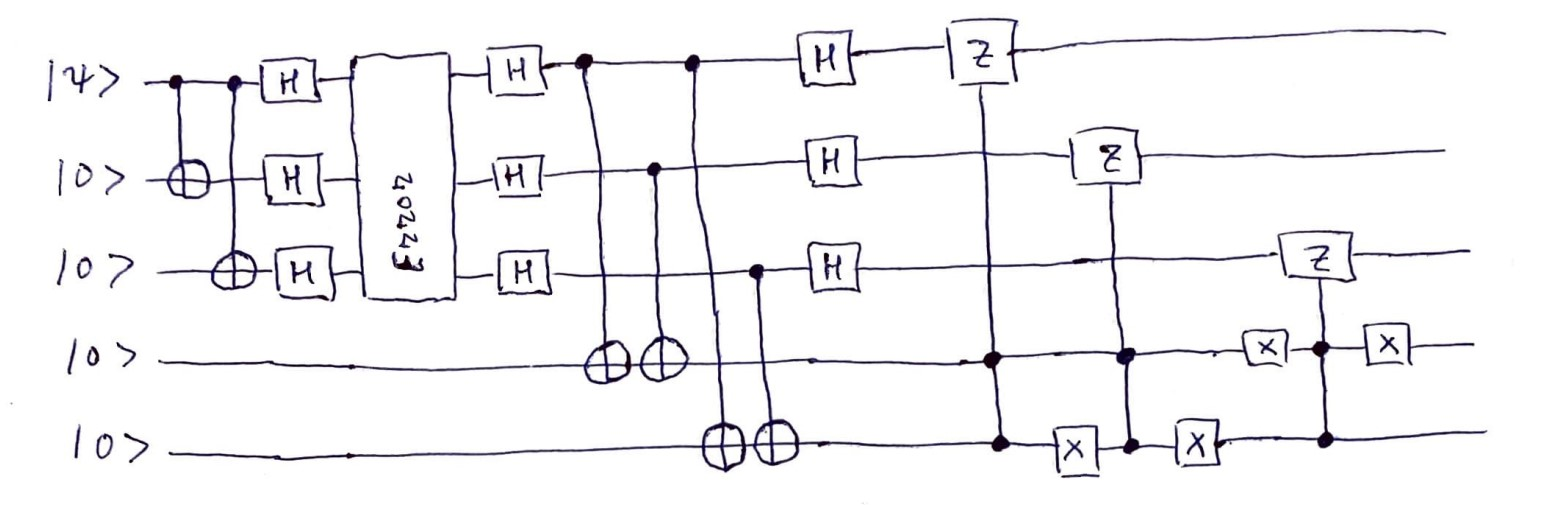

In [13]:
Image("circuit.jpg")

Создаём функцию, которая кодирует входное квантовое состояние.

In [14]:
def code_correction(psi, n):
    psi = two_qubit_gate(psi, CNOT, n, 0, 1)
    psi = two_qubit_gate(psi, CNOT, n, 0, 2)

    psi = one_qubit_gate(psi, H, n, 0)
    psi = one_qubit_gate(psi, H, n, 1)
    psi = one_qubit_gate(psi, H, n, 2)
    return psi

Создаём функцию, которая реализует процедуру исправления фазовой ошибки.

In [15]:
def error_syndrom(psi, n):
    psi = one_qubit_gate(psi, H, n, 0)
    psi = one_qubit_gate(psi, H, n, 1)
    psi = one_qubit_gate(psi, H, n, 2)

    psi = two_qubit_gate(psi, CNOT, n, 0, 3)
    psi = two_qubit_gate(psi, CNOT, n, 1, 3)
    psi = two_qubit_gate(psi, CNOT, n, 0, 4)
    psi = two_qubit_gate(psi, CNOT, n, 2, 4)

    psi = one_qubit_gate(psi, H, n, 0)
    psi = one_qubit_gate(psi, H, n, 1)
    psi = one_qubit_gate(psi, H, n, 2)

    psi = three_qubit_gate(psi, TOFFOLI_Z, n, 0, 3, 4)

    psi = one_qubit_gate(psi, X, n, 4)
    psi = three_qubit_gate(psi, TOFFOLI_Z, n, 1, 3, 4)
    psi = one_qubit_gate(psi, X, n, 4)

    psi = one_qubit_gate(psi, X, n, 3)
    psi = three_qubit_gate(psi, TOFFOLI_Z, n, 2, 3, 4)
    psi = one_qubit_gate(psi, X, n, 3)
    return psi

Создаём функцию, которая редуцирует вспомогательные 2 кубита, то есть мы переходим от матрицы плотности 5 кубитов к матрице плотности 3 кубитов.

In [16]:
def get_reduce_state(psi, n):
    rho_finish = np.tensordot(psi.reshape((2 ** (n - 2), 4, 1)), psi.reshape((1, 2 ** (n - 2), 4)).conjugate(), axes=([2], [0]))
    rho_finish_reduce = np.trace(rho_finish, axis1=1, axis2=3)
    rho_finish_reduce = rho_finish_reduce.reshape((2 ** (n - 2), 2 ** (n - 2)))
    u, s, vh = np.linalg.svd(rho_finish_reduce)
    psi_reduce = u.T[0]
    return psi_reduce

Создаём функцию, которая вычисляет фиделити между двумя чистыми состояниями.

In [17]:
def fidelity_pure(psi_1, psi_2):
    return np.abs(np.dot(psi_1, psi_2.conjugate())) ** 2

Вычисляем идеальное выходное квантовое состояние, получаемое после процедуры исправления ошибки.

In [18]:
psi_exact = code_correction(psi_0, n)
psi_exact = error_syndrom(psi_exact, n)
psi_exact = get_reduce_state(psi_exact, n)

In [19]:
print(psi_exact)

[-0.35355339-1.08983500e-17j  0.07071068-3.46410162e-01j
  0.07071068-3.46410162e-01j -0.35355339-9.55238083e-19j
  0.07071068-3.46410162e-01j -0.35355339-9.55238083e-19j
 -0.35355339-9.55238083e-19j  0.07071068-3.46410162e-01j]


Действуем оператором $\hat{Z}$ на каждый кубит кода.

In [20]:
psi_z_1 = code_correction(psi_0, n)
psi_z_1 = one_qubit_gate(psi_z_1, Z, n, 0) # Фазовая ошибка на 1-ом кубите
psi_z_1 = error_syndrom(psi_z_1, n)
psi_z_1 = get_reduce_state(psi_z_1, n)

In [21]:
psi_z_2 = code_correction(psi_0, n)
psi_z_2 = one_qubit_gate(psi_z_2, Z, n, 1) # Фазовая ошибка на 2-ом кубите
psi_z_2 = error_syndrom(psi_z_2, n)
psi_z_2 = get_reduce_state(psi_z_2, n)

In [22]:
psi_z_3 = code_correction(psi_0, n)
psi_z_3 = one_qubit_gate(psi_z_3, Z, n, 2) # Фазовая ошибка на 3-ем кубите
psi_z_3 = error_syndrom(psi_z_3, n)
psi_z_3 = get_reduce_state(psi_z_3, n)

Найдём фиделити между новым выходным состоянием и идеальным состоянием, полученным в предыдущем пункте. Убеждаемся, что фиделити равно 1, значит, возникновение фазовой ошибки в любом кубите кода не изменяет квантовое состояние.

In [23]:
print(fidelity_pure(psi_exact, psi_z_1), fidelity_pure(psi_exact, psi_z_2), fidelity_pure(psi_exact, psi_z_3))

0.9999999999999996 0.9999999999999996 0.9999999999999996


Создаём функцию, которая генерирует список однокубитовых матриц Крауса размера $2$ на $2$.

In [24]:
def get_list_kraus(p):
    e_0 = np.sqrt(1 - p) * I
    e_1 = np.sqrt(0.9 * p) * Z
    e_2 = np.sqrt(0.1 * p) * Y
    list_kraus = [e_0, e_1, e_2]
    return list_kraus

Создаём функцию, которая генерирует список однокубитовых матриц Крауса размера $n$ на $n$.

In [25]:
def get_list_kraus_n(p, n, k):
    e_0 = np.sqrt(1 - p) * I
    e_1 = np.sqrt(0.9 * p) * Z
    e_2 = np.sqrt(0.1 * p) * Y
    list_e = [e_0, e_1, e_2]
    list_kraus = [np.kron(np.kron(np.eye(2 ** k, dtype=complex), e), np.eye(2 ** (n - k - 1), dtype=complex)) for e in list_e]
    return list_kraus

Создаём функцию, реализующую корневой подход. На вход подаётся матрица $\psi$, задающая входное состояние, которая имеет форму ($n$, $r$). Тогда выходное состояние описывается матрицей ($E_1$ $\psi$, $E_2$ $\psi$, ... , $E_k$ $\psi$), которая имеет форму ($n$, $r k$).

In [26]:
def one_qubit_kraus(psi, list_kraus):
    list_psi = [np.dot(kraus, psi) for kraus in list_kraus]
    psi = list_psi[0]
    for i in range(0, len(list_kraus) - 1, 1):
        psi = np.hstack([psi, list_psi[i + 1]])
    return psi

Создаём функцию, которая вычисляет частичный след по $4$ и $5$ кубиту с целью получения редуцированной матрицы плотности первых трёх кубитов.

In [27]:
def get_reduce_rho(rho_n, n):
    rho_n_tensor = rho_n.reshape((2 ** (n - 2), 4, 2 ** (n - 2), 4))
    rho_reduce = np.trace(rho_n_tensor, axis1=1, axis2=3)
    return rho_reduce

Создаём функцию, которая реализует действие ошибки, заданной операторами Крауса на каждый из первых трёх кубитов.

In [28]:
def get_scheme_kraus(psi_0, p, n):
    psi_kraus = code_correction(psi_0.reshape((2 ** n, 1)), n)
    
    psi_kraus = one_qubit_kraus(psi_kraus, get_list_kraus_n(p, n, 0))
    psi_kraus = one_qubit_kraus(psi_kraus, get_list_kraus_n(p, n, 1))
    psi_kraus = one_qubit_kraus(psi_kraus, get_list_kraus_n(p, n, 2))
    
    psi_kraus = error_syndrom(psi_kraus, n)
    
    rho_n = np.dot(psi_kraus, psi_kraus.T.conjugate())
    rho_reduce = get_reduce_rho(rho_n, n)
    return rho_reduce

In [29]:
from scipy.linalg import sqrtm

Создаём функцию, которая вычисляет фиделити между двумя матрицами плотности.

In [30]:
def fidelity(rho, sigma):
    return np.abs(np.trace(sqrtm(sqrtm(rho) @ sigma @ sqrtm(rho)))) ** 2

Создаём функцию, которая реализует действие ошибки, заданной операторами Крауса только на один кубит без кода коррекции (тоже с использованием корневого подхода).

In [31]:
def get_scheme_kraus_1_qubit(psi, p):
    psi = psi.reshape((2, 1))
    psi_kraus = one_qubit_kraus(psi, get_list_kraus(p))
    rho = np.dot(psi_kraus, psi_kraus.T.conjugate())
    return rho

Определяем массив значений вероятностей ошибок на отрезке $[0, p_{\max}]$.

In [32]:
p_max = 0.7
list_p = np.linspace(0, p_max, 71)

Определяем матрицу плотности, которая получается на выходе трёхкубитовой схемы без ошибок.

In [33]:
rho_exact = np.dot(psi_exact.reshape((8, 1)), psi_exact.reshape(1, 8).conjugate())

Определяем массив фиделити между точной матрицей плотности и матрицей плотности с ошибками для всех значений $p$ из массива значений вероятности.

In [34]:
list_fidelity_code_correction = np.array([fidelity(rho_exact, get_scheme_kraus(psi_0, p, n)) for p in list_p])

Теперь зададим матрицу плотности входного состояния одного первого кубита.

In [35]:
psi_0_1_qubit = (1 / np.sqrt(5)) * np.array([np.sqrt(2), -1j * np.sqrt(3)], dtype=complex)
rho_0 = np.dot(psi_0_1_qubit.reshape((2, 1)), psi_0_1_qubit.reshape((1, 2)).conjugate())

Найдём зависимость фиделити от вероятности ошибки на отрезке $[0, p_{\max}]$.

In [36]:
list_fidelity_1_qubit = np.array([fidelity(rho_0, get_scheme_kraus_1_qubit(psi_0_1_qubit, p)) for p in list_p])

Построим графики обеих зависимостей фиделити от $p$ на отрезке $[0, p_{\max}]$.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

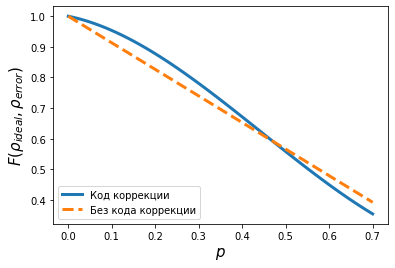

In [38]:
fig, ax = plt.subplots()
plt.plot(list_p, list_fidelity_code_correction, lw=3, alpha=1, label='Код коррекции')
plt.plot(list_p, list_fidelity_1_qubit, '--', lw=3, alpha=1, label='Без кода коррекции')
ax.legend(loc='lower left')
ax.minorticks_off()
plt.xlabel(r'$p$', fontsize=15)
plt.ylabel(r'$F(\rho_{ideal}, \rho_{error})$', fontsize=15)
plt.show()

Найдём точку, в которой вероятности ошибок пересекаются.

In [39]:
i_equal = 0
for i in range(len(list_p)):
    if (list_fidelity_code_correction[i] > list_fidelity_1_qubit[i]) and (list_fidelity_code_correction[i + 1] <= list_fidelity_1_qubit[i + 1]):
        i_equal = i
print(list_p[i_equal])

0.46


Итак, код коррекции ошибок целесообразно использовать при значений $p$ на отрезке $[0, 0.46]$.